__Что щас не сделано__
1. Не считаются географические координаты, не хранятся в выходном слое
2. Не фильтруются nan (?)
3. Нормализации нет, аугментации, регуляризации какой
4. Не прописана оценка качества на тестовой выборке
5. Да и вообще модель не училась. И я пока не в курсе, рабочая ли она

__Вопросики__

1. Если нам нарезать на патчи 5х5 весь тренировочный участок, получается 20+ млн патчей, память забивается за раз. Если генерировать при создании датасета патчи рандомно и фиксировать их количество, то, фиксируя random seed, мы же будем получать одни и те же патчи при запуске? И что если мы хотим в каждую эпоху класть новую случайную порцию патчей? Если мы набранные патчи генерируем до даталоадера, то на цикле обучения новые объекты уже брать негде...

Импорт необходимых библиотек

In [1]:
import numpy as np
from osgeo import gdal
from tqdm import tqdm
from tqdm import trange
import random
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import PrecisionRecallDisplay

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
torch.cuda.is_available()

True

In [ ]:
# про вычисление координат пиксела
# https://stackoverflow.com/questions/50191648/gis-geotiff-gdal-python-how-to-get-coordinates-from-pixel
# xoffset, px_w, rot1, yoffset, px_h, rot2 = ds.GetGeoTransform()

# # supposing x and y are your pixel coordinate this 
# # is how to get the coordinate in space.
# posX = px_w * x + rot1 * y + xoffset
# posY = rot2 * x + px_h * y + yoffset

# # shift to the center of the pixel
# posX += px_w / 2.0
# posY += px_h / 2.0

Нам понадобятся для работы некоторые функции, соберем их тут, чтобы потом не мешались

Прежде всего, нам нужен класс для подготовки датасета. Он должен
1. Нарезать на патчи (заданного размера)
2. Определять класс центрального пиксела патча (на основе соответственного патча маски)
3. Вычислять координаты этого пиксела и складывать их куда-то, чтобы потом можно было восстановить изображение
4. Кстати, раз мы режем на патчи после отделения тестового и валидационного куска, надо также подавать значения порогов отделения, чтобы восстанавливать координаты?

In [16]:
class Patcher(Dataset):
    def __init__(self, image, mask, transform, patch_size, size=10000, bound=0, seed=42):
        super().__init__()
        
        
        self.image = image
        self.mask = mask
        self.transform = transform
        self.patch_size = patch_size
        self.size = size
        self.rng = np.random.RandomState(seed)
        self.im_h, self.im_w = image.shape[0], image.shape[1]             

    def __getitem__(self, indx):
        central_x = self.rng.randint(0, self.im_w - (self.patch_size - 1))
        central_y = self.rng.randint(0, self.im_h - (self.patch_size - 1))
        half_patch = self.patch_size // 2
        if (self.image[(central_y - half_patch):(central_y + half_patch + 1), 
                 (central_x - half_patch):(central_x + half_patch + 1)] != 0).all():
            patch = self.image[(central_y - half_patch):(central_y + half_patch + 1), 
                          (central_x - half_patch):(central_x + half_patch + 1)]
            label = self.mask[central_y][central_x]
            coords = (0, 0) # geographical, now dummy
            return self.transform(patch), torch.tensor(label).float(), torch.tensor(coords) # зачем флоат лейблам?

    def __len__(self):
        return self.size # 5х5 патчей получается 21,5 млн штук, хотелось бы ограничивать

In [3]:
# функция для валидации
def validate(model,
             criterion,
             val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train, coords = batch
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train) # get predictions
            loss = criterion(y_pred, y_train) # compute loss
            loss_history.append(loss.cpu().detach().numpy()) # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history # mean loss and history

In [7]:
# функция для обучения
def train(model, train_data, test_data, criterion, optimizer, num_epochs = 10):
    loss_hist = []
    accuracy_lst = []
    epochs = trange(num_epochs)
    for epoch in tqdm(epochs):
        ep_loss = 0
        for batch in train_data:
            print(batch.size)
            imgs, labels, coords = batch
            print(imgs.size)
            print(labels.size)
            print(coords.size)
            imgs, labels = imgs.to(device), labels.to(device)     
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            ep_loss += loss.item()
        loss_hist.append(ep_loss / len(train_data))
        
        accuracy = validate(model, test_data)
        accuracy_lst.append(accuracy)

        epochs.set_description(f"Epoch={epoch}  loss={loss_hist[epoch]:.4}")
    return accuracy_lst, loss_hist

Задаем пути на изображение, для которого будет проводиться классификация, и на маску (label)

In [5]:
raster_path = "D:/oni/from_lakm/tiffs_clip/subalos_S1B_20191021_.tif"
mask_path = "D:/oni/from_lakm/tiffs_clip/forest_mask.tif"

Открытие изображений, сохранение информации о пространственной привязке для будущего выходного изображения

In [6]:
image = gdal.Open(raster_path, gdal.GA_ReadOnly)
# получаем инфо о пространственной привязке,
# потому что просто картинка на выходе нам не нужна
geo_transform = image.GetGeoTransform()
projection = image.GetProjectionRef()

mask = gdal.Open(mask_path, gdal.GA_ReadOnly)

In [47]:
print(geo_transform)
print(projection)

(499997.52242239844, 10.0, 0.0, 6951689.007115613, 0.0, -10.0)
PROJCS["WGS_1984_UTM_Zone_52N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32652"]]


Информация о проекции очень важна для конечного изображения, но очень бессмысленна для определения координат пикселов. Кстати, а почему я решила, что результирующее изображение будет иметь те же координаты? Придется train-test слеплять...

In [8]:
print('image rows and cols:', image.RasterYSize, image.RasterXSize)
print('mask rows and cols:', mask.RasterYSize, mask.RasterXSize)
print('image bands:', image.RasterCount)
print('mask vs image rows:', mask.RasterYSize == image.RasterYSize)
print('mask vs image cols:', mask.RasterXSize == image.RasterXSize)
print('Aaaaaaaaaaaaaaaaaaaaaaaaaaaa')

image rows and cols: 6146 5008
mask rows and cols: 6146 5009
image bands: 2
mask vs image rows: True
mask vs image cols: False
Aaaaaaaaaaaaaaaaaaaaaaaaaaaa


Наш снимок в пикселах имеет размер 6146 на 5008, а также содержит 2 канала: это две поляризации (в случае с данными с открытого спутника Sentinel-1) VV и VH. 

А у маски другой размер! На один пиксел! За что! Раз мы сохранили инфу о простанственной привязке  для снимка, придется маску чуть изменить. Визуальный анализ показывает, что у маски на одну первую колонку больше. Спрашивается, почему, если я кропала их всех вместе, но ладно

Переводим снимок в матричку

In [9]:
image_array = image.ReadAsArray()
image = None # предлагают прибираться за собой
mask_array = mask.ReadAsArray()
mask = None

image_array = np.stack(image_array, axis=2) # move bands to end
# array = np.reshape(array, [rows * cols, bands]) # если хочешь вытянуть в колбаску

mask_array = np.delete(mask_array, 0, 1) # del first column

In [10]:
print(image_array.shape)
print(mask_array.shape)

(6146, 5008, 2)
(6146, 5008)


У всех снимков (не маски) есть в пределах охвата маски участки, где снимков нет:

Судя по всему, за NaN пока что отвечают нолики. Заменять их на NaN или нет?.. Пока не будем

In [9]:
image_array[0][0][0] == 0.0

True

Наверное, стоит визуализировать кусочки изображений

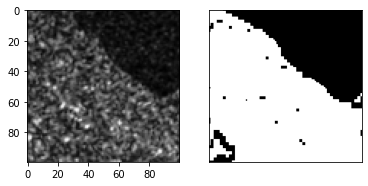

In [11]:
figure1 = image_array[1000:1100, 600:700, :1] # ищем образцово-показательный кусочек
figure2 = mask_array[1000:1100, 600:700]

fig, axis = plt.subplots(1, 2)
# plt.figure(figsize=(6, 6))
axis[0].imshow(figure1, cmap='Greys_r')
axis[1].imshow(figure2, cmap='Greys_r')
plt.grid(False)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()  

Судя по всему, лес (1) белый на маске. Можно обратить внимание на то, что на снимке в выбранной поляризации не_лес темнее

Настало время резать на train-test. Раз мы замыслили кросс-валидацию, нужно ли нам отрезать валидационный кусок еще отдельно? Наверное, пока я не придумала, как учить с кросс-валидацией, сделаем. Отрежем нижние 20 % снимка на тест, преднижние 10 % снимка на валидацию. И что, мы будем потом в статье нижнюю колбаску снимка показывать? Как глупо...

In [11]:
# мне хочется резать по круглым числам, поэтому
bound_val = int(image_array.shape[0] * 0.07) * 10 # тут пришлось отбросить единицы при округлении 1/10 от числа
bound_test = int(image_array.shape[0] * 0.8) # тут округление вниз кратно 10, мне нравится

train_image = image_array[:bound_val]
train_labels = mask_array[:bound_val]

val_image = image_array[bound_val:bound_test]
val_labels = mask_array[bound_val:bound_test]

test_image = image_array[bound_test:]
test_labels = mask_array[bound_test:]

In [12]:
print(train_image.shape) # 6146 rows total
print(train_labels.shape)
print(val_image.shape)
print(val_labels.shape)
print(test_image.shape)
print(test_labels.shape)

(4300, 5008, 2)
(4300, 5008)
(616, 5008, 2)
(616, 5008)
(1230, 5008, 2)
(1230, 5008)


In [22]:
(4300 - 4) * (5008 - 4)

21497184

Будем ли мы баловаться трансформациями?

In [13]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.RandomAutocontrast(p=0.3),
#     transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.01, 2.0)),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225]),
])

Режем на патчи. Готовим датасет

In [19]:
patch_size = 5
train_dataset = Patcher(train_image, train_labels, train_transform, patch_size, size=100000)
valid_dataset = Patcher(val_image, val_labels, valid_transform, patch_size, bound=bound_val)

In [20]:
print(len(train_dataset))
print(len(valid_dataset))

100000
10000


In [21]:
train_dataset[0]

(tensor([[[0.0123, 0.0160, 0.0169, 0.0177, 0.0167],
          [0.0126, 0.0136, 0.0125, 0.0128, 0.0145],
          [0.0112, 0.0141, 0.0098, 0.0089, 0.0105],
          [0.0122, 0.0147, 0.0113, 0.0101, 0.0108],
          [0.0095, 0.0143, 0.0158, 0.0154, 0.0140]],
 
         [[0.0302, 0.0373, 0.0586, 0.0830, 0.0627],
          [0.0327, 0.0497, 0.0605, 0.0563, 0.0385],
          [0.0344, 0.0437, 0.0464, 0.0367, 0.0294],
          [0.0369, 0.0263, 0.0280, 0.0401, 0.0439],
          [0.0406, 0.0259, 0.0296, 0.0408, 0.0392]]]),
 tensor(1.),
 tensor([0, 0]))

In [22]:
valid_dataset[0]

(tensor([[[0.0136, 0.0161, 0.0128, 0.0069, 0.0047],
          [0.0127, 0.0134, 0.0121, 0.0091, 0.0045],
          [0.0116, 0.0095, 0.0136, 0.0161, 0.0124],
          [0.0081, 0.0068, 0.0123, 0.0169, 0.0189],
          [0.0059, 0.0073, 0.0095, 0.0122, 0.0161]],
 
         [[0.0273, 0.0403, 0.0479, 0.0385, 0.0412],
          [0.0385, 0.0535, 0.0546, 0.0413, 0.0309],
          [0.0784, 0.0646, 0.0471, 0.0371, 0.0281],
          [0.0432, 0.0503, 0.0459, 0.0329, 0.0236],
          [0.0307, 0.0511, 0.0609, 0.0407, 0.0253]]]),
 tensor(1.),
 tensor([0, 0]))

In [26]:
batch_size = 8

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          shuffle=False)

Собираем модель

In [27]:
len(train_loader)

12500

In [24]:
class CNN_s1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(2, 32, 3, stride=1, padding=1), # shape: [32,5,5]
            nn.Dropout(),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1, padding=1), # shape: [32,5,5]
            nn.Dropout(),
            nn.ReLU(), 
            nn.Flatten(),
            nn.Linear(32*5*5, 64),
            nn.Dropout(),
            nn.ReLU(), 
            nn.Linear(64, 2) # 0 и 1, без softmax, тк кросс-энтропию используем
        )

    def forward(self, x):
        scores = self.conv_stack(x) 
        return scores

In [32]:
batch = next(iter(train_loader))
# batch
imgs, labels, coords = batch
print(imgs.size()) # опа, каналы у нас на первое место вылезли
print(labels.size())
print(coords.size())

torch.Size([8, 2, 5, 5])
torch.Size([8])
torch.Size([8, 2])


Учимся

In [25]:
model_cnn = CNN_s1().to(device)
# optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
accuracy, loss_hist = train(model_cnn, train_loader, valid_loader, criterion, optimizer, num_epochs = 10)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


TypeError: object of type 'NoneType' has no len()

Походу я складываю пустышки в патчер, если условие в нем не выполняется

In [ ]:
plt.plot(range(10), loss_hist)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [ ]:
plt.plot(range(10), accuracy)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.show()

где-то тут оцениваем качество

In [ ]:
# mathews corr, roc auc, pres recall
# PR-curve
scores = KNN.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, scores)
knn_auc_pr = auc(recall, precision)
display = PrecisionRecallDisplay.from_estimator(model_cnn, X_test, y_test)
_ = display.ax_.set_title("Precision-Recall curve")

In [ ]:
# ROC-curve
roc = roc_auc_score(y_score=x_train, y_true=y_train) 
plot_roc_curve(model_cnn, X_test, y_test)

Где-то тут собираем всё в один снимок

In [ ]:
result_image = 0 # model output

Выгружаем полученное изображение в реальный мир

In [ ]:
# дадим ему имя и место
out_raster = "D:/oni/from_lakm/out/result.tif" 

def createGeotiff(out_raster, data, geo_transform, projection):
    # Create a GeoTIFF file with the given data
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    rasterDS = driver.Create(out_raster, cols, rows, 1, gdal.GDT_Int32) # или не инт?
    rasterDS.SetGeoTransform(geo_transform)
    rasterDS.SetProjection(projection)
    band = rasterDS.GetRasterBand(1)
    band.WriteArray(data)
    rasterDS = None

# экспорт результата
createGeotiff(out_raster, result_image, geo_transform, projection)

Песочница

In [30]:
b = np.array([[1,2,3], [4,5,6], [7,8,9]]) #, [7,8,9]
b

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [27]:
b[:2, :2]

array([[1, 2],
       [4, 5]])

In [33]:
for i in range(b.shape[0] - 1):
    for j in range(b.shape[1] - 1):
        print(b[i:i+2, j:j+2])

[[1 2]
 [4 5]]
[[2 3]
 [5 6]]
[[4 5]
 [7 8]]
[[5 6]
 [8 9]]


In [36]:
b[5//2][2]

9

In [38]:
a = 360
if (image_array[a:a + 5, :5] == 0).all():
    print('yas')
else:
    print('no')

no


In [36]:
(image_array[360:365, :5] == 0).all()

False

На посмотреть

https://github.com/d-smit/sentinel2-deep-learning

https://github.com/scikit-learn/scikit-learn/blob/36958fb24/sklearn/feature_extraction/image.py#L323

In [42]:
# Куда-то в патчер нужно засунуть вычисление координат центрального пиксела и складывание этого знания в датасет
# В начале нам понадобится нарезатель на патчи больших снимков
# Еще он должен узнавать и записывать класс 
# не храним, а на основе свалки координат выбираем патч в гет айтем. а в длине длина свалки координат
# class Patcher(Dataset):
#     def __init__(self, image, mask, transform, patch_size, bound=0, seed=42):
#         super().__init__()
#         self.transform = transform
#         self.rng = np.random.RandomState(seed)
#         self.patches = []
#         self.labels = []
#         self.coords = []
#         im_h, im_w = image.shape[0], image.shape[1]
#         for row in tqdm(range(im_h - (patch_size - 1))):
#             for col in range(im_w - (patch_size - 1)):
#                 if (image[row:row + patch_size, col:col + patch_size] == 0).all(): # empty pixels, go away
#                     break
#                 else:
#                     continue
#                 patch = image[row:row + patch_size, col:col + patch_size]
#                 self.patches.append(patch)
                
#                 label = mask[row + patch_size // 2][col + patch_size // 2] # центральный пиксел
#                 self.labels.append(label)
                
#                 coord = (0, 0)
#                 self.coords.append(coord)
                
#                 # (4300 - 4) * (5008 - 4) = 21 497 184 патчей
#                 # где-то тут память забивается и всё умирает


#     def __getitem__(self, indx):
#         return self.transform(self.patches[indx]), torch.tensor(self.labels[indx]).float(), torch.tensor(self.coords[indx])

#     def __len__(self):
#         return 10000
# #         return len(self.patches)